<a href="https://colab.research.google.com/github/ekrell/shap_multiband/blob/main/EuroSAT_All_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchsat

In [ ]:
# Options
TRAIN = False # Load trained model instead

In [ ]:
url_data = "/content/drive/MyDrive/Data/"
url_python = "/content/drive/MyDrive/Python/"
url_models = "/content/drive/MyDrive/Models/"
path_meanSD = url_data + "/" + "mean_sd.txt"
path_model = url_models + "/" + "eurosat_landuse.pt"

In [ ]:
# Torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
# Torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
import torchvision.models as models
# Torchsat
import torchsat.transforms.functional as F
import torchsat.transforms.transforms_cls as T_cls
from torchsat.transforms import transforms_cls
import torchsat.datasets as datasets
from torchsat.datasets.folder import DatasetFolder
from torchsat.datasets.utils import tifffile_loader
import torchsat.models
from torchsat.models.classification.resnet import resnet18, resnet34, resnet50, resnet101, resnet152, resnext50_32x4d, resnext101_32x8d, wide_resnet50_2, wide_resnet101_2
# Sci
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from PIL import Image
# General
import matplotlib.pyplot as plt
import copy
from collections import namedtuple
import os
import random
import shutil
import time
from pathlib import Path
import math

# Dataset
EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification

    Helber, Patrick, et al. "Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification." IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing 12.7 (2019): 2217-2226.

- Images: 27000
- Size: 64x64 (13 bands)
- Classes:
  - AnnualCrop (3000)
  - Forest (3000)
  - HerbaceousVegetation (3000)
  - Highway (2500)
  - Industrial (2500)
  - Pasture (2000)
  - PermanentCrop (2500)
  - Residential (3000)
  - River (2500)
  - SeaLake (3000) 
- Bands:
  - B01: Aerosols
  - B02: Blue
  - B03: Green
  - B04: Red
  - B05: Red edge 1
  - B06: Red edge 2
  - B07: Red edge 3
  - B08: NIR
  - B08A: Red edge 4
  - B09: Water vapor
  - B10: Cirrus
  - B11: SWIR 1
  - B12: SWIR 2

In [ ]:
# Data paths
projectDir = Path(url_data + "/" + "EuroSatAllBands/")
imgDir = Path(projectDir, "ImagesSmallSep")

In [ ]:
# Set random seeds for reproducability
# SEED = 1234
# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

In [ ]:
import os
import random
from glob import glob
from pathlib import Path

import click
import numpy as np
import tifffile
from PIL import Image
from tqdm import tqdm

def img_loader(fp):
    if Path(fp).suffix.lower() in [".jpg", ".jpeg", ".png"]:
        arr = np.array(Image.open(fp))
    else:
        arr = tifffile.imread(fp)
    return arr

def calcuate_mean_std(root, percent, channels, maxvalue, extension):
    files = [x for x in Path(root).glob('**/*')]
    files = [x for x in files if os.path.splitext(x)[-1].lower() == extension]
    random.shuffle(files)
    files = files[0: int(len(files) * percent)]

    if not files:
        print("INFO: No Image Found!")
        return
    else:
        print("Number of files to use: {}".format(len(files)))

    pixel_num = 0  # store all pixel number in the dataset
    channel_sum = np.zeros(channels)
    channel_sum_squared = np.zeros(channels)
    for item in tqdm(files):
        arr = img_loader(item)
        arr = arr / maxvalue
        pixel_num += arr.shape[0] * arr.shape[1]
        channel_sum += np.sum(arr, axis=(0, 1))
        channel_sum_squared += np.sum(np.square(arr), axis=(0, 1))

    mean = channel_sum / pixel_num
    std = np.sqrt(channel_sum_squared / pixel_num - np.square(mean))

    print("scaled  mean:{} \nscaled  std: {} ".format(mean, std))
    print("orginal mean: {} \norginal std: {}".format(mean * maxvalue, std * maxvalue))

    return mean, std, mean * maxvalue, std * maxvalue

In [ ]:
meanSD_fromTrain = False

# 12-bit satellite image, values between 0 - 4095 (not 255)
maxBN = 4095
n_channels = 13

if meanSD_fromTrain:
  # Calculate training data mean and std. dev.
  cache = True
  useCache = True
  # Percent of training data images to include in calculating the mean, std. dev.
  percDataForCalc = 0.5 

  if useCache == False:
    mean_scaled, std_scaled, mean_orig, std_orig = calcuate_mean_std(Path(imgDir, "train"), .5, n_channels, maxBN, ".tif")
    meanSD = [mean_scaled, std_scaled, mean_orig, std_orig]
    if cache:
      np.savetxt(path_meanSD, meanSD)
  else:
    meanSD = np.loadtxt(path_meanSD)
else:
  # Use 0.5 to scale all to [-1, 1]
  mean = [0.5 for i in range(n_channels)]
  std = [0.5 for i in range(n_channels)]
  meanSD = [mean, std]

In [ ]:
meanSD

[[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]]

In [ ]:
# Define transformers
train_transform = T_cls.Compose([
    T_cls.RandomHorizontalFlip(),
    T_cls.RandomVerticalFlip(),
    T_cls.ToTensor(),
    # T_cls.Normalize(mean=meanSD[0], std=meanSD[1]),
])
val_transform = T_cls.Compose([
    T_cls.ToTensor(),
    # T_cls.Normalize(mean=meanSD[0], std=meanSD[1]),
])

# Load data from folders
trainData = datasets.folder.DatasetFolder(Path(imgDir, "train"), datasets.utils.tifffile_loader, ".tif", transform=train_transform)
valData   = datasets.folder.DatasetFolder(Path(imgDir, "val"),   datasets.utils.tifffile_loader, ".tif", transform=val_transform)
testData  = datasets.folder.DatasetFolder(Path(imgDir, "test"),  datasets.utils.tifffile_loader, ".tif")

# Data information
classes = trainData.classes
n_classes = len(classes)
n_train = len(trainData)
n_val = len(valData)
n_test = len(testData)

In [ ]:
# Check valid data
doCheckValidData = False # SLOW -> set to true if problems

if doCheckValidData:
  bad_idxs = []
  for i in range(n_train):
    try:
      x, y = trainData[i]
    except:
      bad_idxs.append(i)
    if (i % 100 == 0):
      print ("{} / {}".format(i, n_train))

  print("Bad training samples: ", len(bad_idxs))
  print(bad_idxs)
  print(trainData.samples[bad_idxs[0]])
else:
  print("Skipped checking for bad data")

Skipped checking for bad data


64 rows, 64 columns, 13 channels.


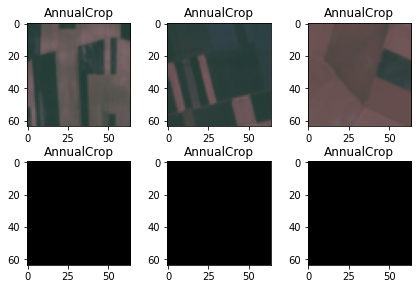

In [ ]:
def imgShow(x, ax=None):
  img = Image.fromarray(np.uint8(x[:,:,1:4][:,:,(2, 0, 1)] >> 4))
  if ax == None:
    plt.imshow(img)
  ax.imshow(img)

def normShow(x, ax=None):
  # img = transforms.ToPILImage()(np.uint8(x[:,:,1:4][:,:,(2, 0, 1)] >> 4)).convert("RGB")
  img = transforms.ToPILImage()(val_transform(x[:,:,1:4][:,:,(2, 0, 1)] >> 4)).convert("RGB")
  if ax == None:
    plt.imshow(img)
  ax.imshow(img)

# Show sample images
fig, axs = plt.subplots(2, 3);
# Train sample
x,y = testData[0]
imgShow(x, ax=axs[0][0]);
axs[0][0].set_title(classes[y]);
# Validate sample
x,y = testData[1]
imgShow(x, ax=axs[0][1]);
axs[0][1].set_title(classes[y]);
# Test sample
x,y = testData[2]
imgShow(x, ax=axs[0][2]);
axs[0][2].set_title(classes[y]);
plt.tight_layout()
# Train sample
x,y = testData[0]
normShow(x, ax=axs[1][0]);
axs[1][0].set_title(classes[y]);
# Validate sample
x,y = testData[1]
normShow(x, ax=axs[1][1]);
axs[1][1].set_title(classes[y]);
# Test sample
x,y = testData[2]
normShow(x, ax=axs[1][2]);
axs[1][2].set_title(classes[y]);
plt.tight_layout()

print("{} rows, {} columns, {} channels.".format(x.shape[0], x.shape[1], x.shape[2]))

# Training

In [ ]:
# Params
torch.backends.cudnn.benchmark = True
printFreq = 10

# Hardware
device = torch.device('cuda')
# Batch size
batchSize = 64

# Initial learning rate
learningRate = 0.1
# epochs
n_epochs = 100

In [ ]:
# Data loaders
train_loader = DataLoader(trainData, batch_size=batchSize, shuffle=True)
val_loader   = DataLoader(valData,   batch_size=batchSize, shuffle=True)

In [ ]:
# Load model
model = resnet18(n_classes, 13)
model.to(device)

# Define learning components
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learningRate)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
def train_one_epoch(model, criterion, optimizer, data_loader, device, epoch, print_freq, writer):
    model.train()
    for idx, (image, target) in enumerate(data_loader):
        image, target = image.to(device, dtype=torch.float), target.to(device)
        output = model(image)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if idx % print_freq == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, idx * len(image), len(data_loader.dataset), 100. * idx / len(data_loader), loss.item()))
            # writer.add_scalar('train/loss', loss.item(), len(data_loader) * epoch + idx)

In [ ]:
def evaluate(epoch, model, criterion, data_loader, device, writer):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for idx, (image, target) in enumerate(data_loader):
            image = image.to(device, dtype=torch.float, non_blocking=True)
            target = target.to(device, non_blocking=True)
            output = model(image)
            loss += criterion(output, target).item()

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

        loss /= len(data_loader.dataset)/data_loader.batch_size

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            loss, correct, len(data_loader.dataset),
            100. * correct / len(data_loader.dataset)))
        # writer.add_scalar('test/loss', loss, len(data_loader) * epoch)
        # writer.add_scalar('test/accuracy', correct / len(data_loader.dataset), epoch)

In [ ]:
if TRAIN:
  # Train
  writer = SummaryWriter(url_models)
  for epoch in range(n_epochs):
    # writer.add_scalar('train/learning_rate', lr_scheduler.get_last_lr()[0], epoch)
    train_one_epoch(model, criterion, optimizer, train_loader, device, epoch, printFreq, writer)
    lr_scheduler.step()
    evaluate(epoch, model, criterion, val_loader, device, writer)
    torch.save(model.state_dict(), os.path.join(url_models, "cls_epoch_{}.pth".format(epoch)))

# Prediction

In [ ]:
class_to_idx = {
        'AnnualCrop': 0,
        'Forest': 1,
        'HerbaceousVegetation': 2,
        'Highway': 3,
        'Industrial': 4,
        'Pasture': 5,
        'PermanentCrop': 6,
        'Residential': 7,
        'River': 8,
        'SeaLake': 9,
    }
idx_to_class = {v: k for k, v in class_to_idx.items()}

ckp = url_models + "/" + "cls_epoch_22.pth"
model.load_state_dict(torch.load(ckp, map_location=torch.device('cuda')))

<All keys matched successfully>

predict class: Residential


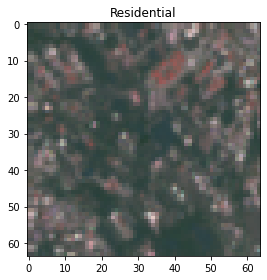

In [ ]:
# Get test image
image, target = testData[200]
# Plot test image
fig, ax = plt.subplots(1);
imgShow(image, ax=ax);
ax.set_title(classes[target]);
plt.tight_layout()

# Convert to tensor
image = F.to_tensor(image)
# Normalize (with train data mean, std. dev.)
# image = F.normalize(image, meanSD[0], meanSD[1])
# Reshape for the model [bands, h, w] -> [batch size, bands, h, w]
image = torch.unsqueeze(image, 0) 
# Place on device
image.to("cpu", dtype=torch.float)

# (image, target) 
# image = image.to(device, dtype=torch.float, non_blocking=True)

model.to("cpu", dtype=torch.double)

model.eval()
with torch.no_grad():
  
  output = model(image)
  predict_class = output.argmax(dim=1,).item()

  print('predict class: {}'.format(idx_to_class.get(predict_class)))

# Save model

In [ ]:
torch.save(model, path_model)